# CartPole

In [1]:
import gym
import numpy as np
from tqdm import tqdm  # shows where we are through training
import matplotlib.pyplot as plt   # to show off results
import pandas as pd
import seaborn as sns

CartPole gives the cart position, cart velocity, pole angle, and pole velocity at tip in the range $\left[ -2.4, 2.4 \right] \times \mathbb{R} \times \left[ -41.8 , 41.8 \right] \times \mathbb{R}$.

In [2]:
env_name = "CartPole-v1"

gamma = 0.98 # discount factor (want it high because we only care about the end)
alpha = 0.05  # learning rate (could probably be even higher since MountainCar is small)

state_size = 4   # state dimension
state_min = [-2.4, -2.5, -41.8, -1.75] # min state output   # note that state_min/max[1] and [3] are arbitrary
state_max = [ 2.4,  2.5,  41.8,  1.75] # max state output

action_size = 2   # 0 (left) or 1 (right)

num_intervals = [12, 25, 30, 25]   # this includes outside of the min and max
num_trials = 500000
test_freq = 500   # after how many trials do we want to look at results?
num_tests = 4    # how many tests in each test
extra_tests = 1000   # at the end, how many additional tests do we want to do that are not rendered?

epsilon = 1  # start by moving randomly
epsilon_min = .01  # minimum epsilon
epsilon_episodes = int(num_trials/2)  # after this many episodes, have epsilon_min

In [3]:
# This is a generic interval maker that makes uniform intervals, there's a VERY good chance that you won't actually want this irl

def interval_maker(mins, maxs, interval_size, prec=5):
    my_list = [[i] for i in mins]   # for the number of dimensions in each state,
                                    # make a list in this list and initialize to the mins
    for i, size in enumerate(interval_size):
        length = round((maxs[i] - mins[i])/(-2+size), prec)   # length of the interval
        for j in range(size-3):
            my_list[i].append(round(my_list[i][-1]+length, prec))  # appended the next cutoff point,
                                                                   # round to 'prec' decimal places
        my_list[i].append(maxs[i])

    return my_list



# A function to map states to indices

def s_to_index(state):
    state_list = [0 for i in range(state_size)]   # will store which intervals we are in
    for i in range(state_size):
        for idx, num in enumerate(state_intervals[i]):
            if state[i] < num:   # break once we have found the interval
                state_list[i] = idx
                break
    output = state_list[0]
    for i in range(1,state_size):
        output += state_list[i]*np.product(num_intervals[:i])
    return int(output)



# A function to select an action based on the current Q table and epsilon

def select_action(state_index, eps, Q):
    if np.random.rand() < eps:   # chance we pick a random action
        return np.random.randint(action_size)
    else:   # otherwise, pick what we think is best
        return np.argmax(Q[state_index])



# Test current Q_table
def tester(Q, env):
    super_total = 0
    for _ in range(num_tests):
        done = False
        total = 0
        s = env.reset()
        while not done:
            s_idx = s_to_index(s)
            a = select_action(s_idx, 0, Q)   # epsilon = 0 means always choose best action
            s, r, done, _ = env.step(a)
            total += r
        super_total += total
    return super_total/num_tests   # return average total score
    


# Efficiently computes moving averages

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [4]:
# Housekeeping stuff
env = gym.make(env_name)   # create environment
epsilon_decay = (epsilon-epsilon_min)/epsilon_episodes # how quickly epsilon decays
# Q_table = np.random.rand(*[np.product(num_intervals), action_size])-0.5   # initialize Q table randomly (centered around 0)
Q_table = np.zeros([np.product(num_intervals), action_size])    # (can also initialize to zero)

state_intervals = interval_maker(state_min, state_max, num_intervals)  # helps determine state
print('[')
for thing in state_intervals:
    print(str(thing) + ',')
print(']')

# For Visualization of Results
rewards_list = []
test_rewards = []

[
[-2.4, -1.92, -1.44, -0.96, -0.48, 0.0, 0.48, 0.96, 1.44, 1.92, 2.4],
[-2.5, -2.28261, -2.06522, -1.84783, -1.63044, -1.41305, -1.19566, -0.97827, -0.76088, -0.54349, -0.3261, -0.10871, 0.10868, 0.32607, 0.54346, 0.76085, 0.97824, 1.19563, 1.41302, 1.63041, 1.8478, 2.06519, 2.28258, 2.5],
[-41.8, -38.81429, -35.82858, -32.84287, -29.85716, -26.87145, -23.88574, -20.90003, -17.91432, -14.92861, -11.9429, -8.95719, -5.97148, -2.98577, -6e-05, 2.98565, 5.97136, 8.95707, 11.94278, 14.92849, 17.9142, 20.89991, 23.88562, 26.87133, 29.85704, 32.84275, 35.82846, 38.81417, 41.8],
[-1.75, -1.59783, -1.44566, -1.29349, -1.14132, -0.98915, -0.83698, -0.68481, -0.53264, -0.38047, -0.2283, -0.07613, 0.07604, 0.22821, 0.38038, 0.53255, 0.68472, 0.83689, 0.98906, 1.14123, 1.2934, 1.44557, 1.59774, 1.75],
]


In [5]:
# Train
for test_num in tqdm(range(num_trials)):
    s = env.reset()   # starting state
    s_idx = s_to_index(s)   # starting state's index
    done = False   # whether we're done with the episode
    total_score = 0  # keep track of total score
    while not done:   # go til done
        a = select_action(s_idx, epsilon, Q_table)   # select action
        new_s, r, done, _ = env.step(a)   # record new state, the reward, and whether we're done ('_' is info we don't want)
        new_s_idx = s_to_index(new_s)   # new index

        if not done:
            Q_table[s_idx, a] = (1-alpha)*Q_table[s_idx, a] + alpha*(r + gamma*np.max(Q_table[new_s_idx]))   # update Q table
        else:
            Q_table[s_idx, a] = (1-alpha)*Q_table[s_idx, a] + alpha*r   # if done, there is no future

        total_score += r   # add to total score

        s = new_s   # update state
        s_idx = new_s_idx   # and state index
    
    rewards_list.append(total_score)   # store reward
    epsilon = max(epsilon_min, epsilon-epsilon_decay)   # decay epsilon
    
    if test_num % test_freq == 0:
        test_rewards.append(tester(Q_table, env))
    

100%|██████████████████████████████████████████████████████████████| 500000/500000 [5:48:38<00:00, 23.90it/s]


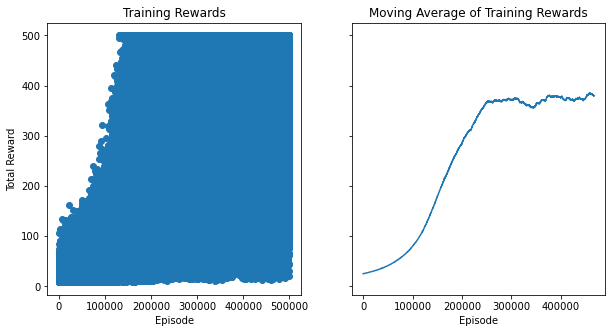

In [6]:
moving_average_len = int(np.floor(len(rewards_list)/15))
moving_average = running_mean(rewards_list, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))

ax1.set_title('Training Rewards')
ax1.scatter([i+1 for i in range(len(rewards_list))], rewards_list)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')

ax2.set_title('Moving Average of Training Rewards')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

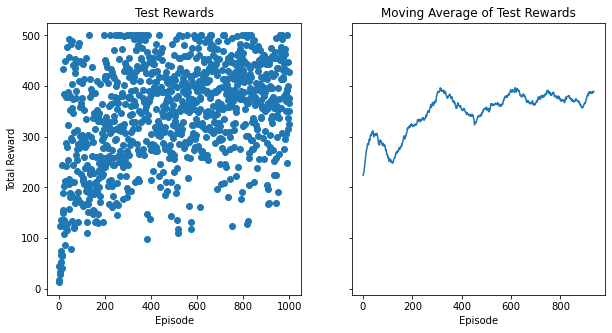

In [7]:
moving_average_len = int(np.floor(len(test_rewards)/15))
moving_average = running_mean(test_rewards, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))

ax1.set_title('Test Rewards')
ax1.scatter([i+1 for i in range(len(test_rewards))], test_rewards)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')

ax2.set_title('Moving Average of Test Rewards')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

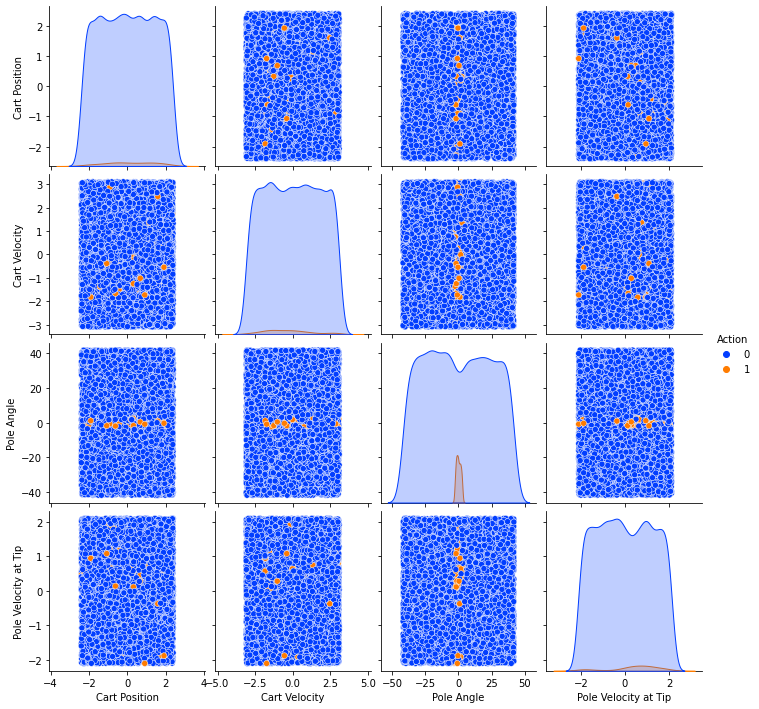

In [8]:
n_dots = 10000
cart_pos = list(np.random.uniform(-2.4, 2.4, n_dots))
cart_vel = list(np.random.uniform(-3.1, 3.1, n_dots))
pole_angle = list(np.random.uniform(-41.8, 41.8, n_dots))
pole_tip_vel = list(np.random.uniform(-2.1, 2.1, n_dots))
Z = []
for i in range(n_dots):
    fake_state_index = s_to_index(np.array([cart_pos[i], cart_vel[i], pole_angle[i], pole_tip_vel[i]]))
    Z.append(select_action(fake_state_index, 0, Q_table))   # select action
# Z = pd.Series(Z)
# colors = {0:'blue', 1:'red'}
# colors = Z.apply(lambda x:colors[x])
# labels = ['Left','Right']

data = {'Cart Position':cart_pos, "Cart Velocity":cart_vel, "Pole Angle":pole_angle, "Pole Velocity at Tip":pole_tip_vel, \
        'Action':Z}
cart_data = pd.DataFrame(data=data)
g = sns.pairplot(cart_data, hue="Action", palette="bright", vars=["Cart Position", "Cart Velocity", "Pole Angle", "Pole Velocity at Tip"])

In [9]:
super_total = 0
for _ in range(extra_tests):
    done = False
    total = 0
    s = env.reset()
    while not done:
        s_idx = s_to_index(s)
        a = select_action(s_idx, 0, Q_table)   # epsilon = 0 means always choose best action
        s, r, done, _ = env.step(a)
        total += r
    super_total += total
for _ in range(num_tests):
    done = False
    total = 0
    s = env.reset()
    env.render()
    while not done:
        s_idx = s_to_index(s)
        a = select_action(s_idx, 0, Q_table)   # epsilon = 0 means always choose best action
        s, r, done, _ = env.step(a)
        env.render()
        total += r
    super_total += total
print("Average Reward: {}".format(round(super_total/(num_tests+extra_tests), 5)))   # return average total score
env.close()

Average Reward: 382.4492


This could be improved with finer intervals and more training, but for Q learning this is pretty good.